In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from matplotlib import dates
import matplotlib.pyplot as plt
import time
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
fadc_MHz = 1024
fadc_sum_bins = 75
E_proton_min = 10           # GeV
E_proton_max = 100000       # GeV
theta_proton_min_deg =  0.0 # deg
theta_proton_max_deg = 10.0 # deg
R_proton = 1500             # m

In [3]:
def get_bin_centers(hist_data):
    bins=np.copy(hist_data[1])
    bins_roll=np.copy(hist_data[1])
    bins=np.pad(bins,1)
    bins_roll=np.roll(np.pad(bins_roll,1),1)
    centers=(bins - bins_roll)[2:-1]/2.0 + hist_data[1][:-1]
    #print(bins_roll)
    #print()
    #print(len(hist_data[0]))
    #print(len(hist_data[1]))
    #print(len(centers))
    #print(centers)
    return centers

In [4]:
def get_bin_min_max(hist_data):
    #
    bins_min=np.copy(hist_data[1])
    bins_max=np.copy(hist_data[1])
    #
    return np.column_stack((bins_min[:-1],bins_max[1:]))

In [5]:
def generate_random_1_over_x_squared(size, x_min, x_max):
    u = np.random.uniform(0, 1, size)
    x = 1 / ((1 / x_min) - u * ((1 / x_min) - (1 / x_max)))
    return x

In [6]:
def get_proton_flux_perm2_pers_persr(e_min, e_max):
  return 5781.68*(1.0/np.power(e_min,1.674)-1.0/np.power(e_max,1.674))

In [7]:
def solid_angle_integral(theta_min_deg,theta_max_deg):
    return  2*np.pi*(np.cos(theta_min_deg/180.0*np.pi) - np.cos(theta_max_deg/180.0*np.pi));

In [8]:
def get_proton_flux_pers( e_min, e_max, theta_min_deg, theta_max_deg, R):
    return get_proton_flux_perm2_pers_persr(e_min, e_max)*solid_angle_integral(theta_min_deg, theta_max_deg)*np.pi*R*R

In [9]:
get_proton_flux_pers( E_proton_min, E_proton_max, theta_proton_min_deg, theta_proton_max_deg, R_proton)

82639605.44796683

In [10]:
def get_data( dirin = '../scratch/simtel_data/NSB386MHz/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv'):
    file_list=get_data_file_list( dirin = dirin, file_prefix = file_prefix, file_suffix = file_suffix)
    if (len(file_list) > 0):
        df = pd.read_csv(file_list[0])
        for i in range(1,len(file_list)):
            dftmp = pd.read_csv(file_list[i])
            df = pd.concat([df,dftmp], ignore_index=True)
    
    return df

In [11]:
#corsika_run1.npe.csv
def get_data_file_list( dirin = '../scratch/simtel_data/NSB386MHz/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv'):
    nfiles=get_n_files(dirin)
    print(dirin)
    print(nfiles)
    file_list=[]
    for i in range(1,nfiles+1):
        filename = str(dirin + file_prefix + str(i) + file_suffix)
        if Path(filename).exists():
            file_list.append(str(dirin + file_prefix + str(i) + file_suffix))
        else:
            print(f"File : {filename} does not exist.")
    return file_list

In [12]:
def get_n_files( dirin='../scratch/simtel_data/NSB386MHz/npe/'):
    nfiles=!ls -l $dirin/*.csv | wc -l
    return int(nfiles[0])

In [13]:
#nfiles=!ls -l ../scratch/simtel_data/NSB386MHz/npe/*.csv | wc -l

In [14]:
df_nsb=get_data(dirin = '../scratch/simtel_data/386MHz/NSB386MHz/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv')
df_gd=get_data(dirin = '../scratch/simtel_data/386MHz/gamma_diffuse/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv')
df_g=get_data(dirin = '../scratch/simtel_data/386MHz/gamma/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv')
df_e=get_data(dirin = '../scratch/simtel_data/386MHz/electron/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv')
df_p=get_data(dirin = '../scratch/simtel_data/386MHz/proton/npe/', file_prefix = 'corsika_run', file_suffix = '.npe.csv')

../scratch/simtel_data/386MHz/NSB386MHz/npe/
71
../scratch/simtel_data/386MHz/gamma_diffuse/npe/
71
../scratch/simtel_data/386MHz/gamma/npe/
71
../scratch/simtel_data/386MHz/electron/npe/
71
../scratch/simtel_data/386MHz/proton/npe/
71


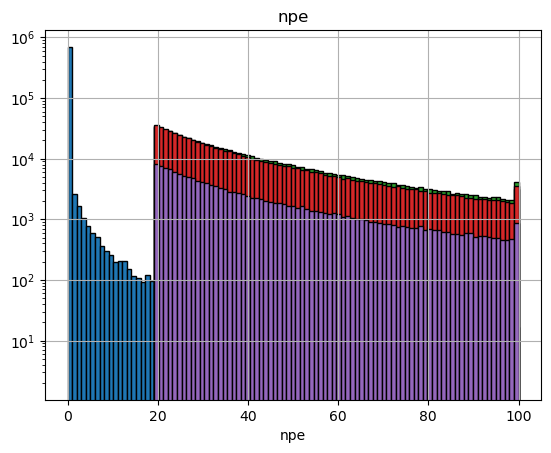

In [15]:
plt.hist(df_nsb['n_pe'].values, bins=np.linspace(0, 100, num=100), edgecolor='black')
plt.hist(df_gd['n_pe'].values, bins=np.linspace(0, 100, num=100), edgecolor='black')
plt.hist(df_g['n_pe'].values, bins=np.linspace(0, 100, num=100), edgecolor='black')
plt.hist(df_e['n_pe'].values, bins=np.linspace(0, 100, num=100), edgecolor='black')
plt.hist(df_p['n_pe'].values, bins=np.linspace(0, 100, num=100), edgecolor='black')

# Add labels and title
plt.xlabel('npe')
plt.ylabel('')
plt.title('npe')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
# Show the plot
plt.show()

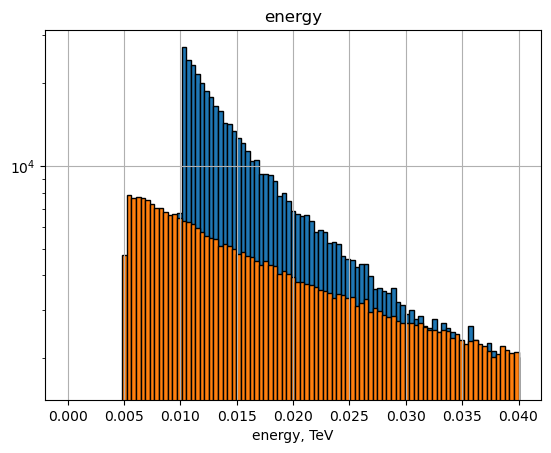

In [16]:
plt.hist(df_nsb['energy'].values, bins=np.linspace(0, 0.04, num=100), edgecolor='black')
plt.hist(df_gd['energy'].values, bins=np.linspace(0, 0.04, num=100), edgecolor='black')
#plt.hist(df_g['energy'].values, bins=np.linspace(0, 0.04, num=100), edgecolor='black')
#plt.hist(df_e['energy'].values, bins=np.linspace(0, 0.1, num=100), edgecolor='black')
#plt.hist(df_p['energy'].values, bins=np.linspace(0, 0.1, num=100), edgecolor='black')
# Add labels and title
plt.xlabel('energy, TeV')
plt.ylabel('')
plt.title('energy')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
# Show the plot
plt.show()

In [17]:
len(df_nsb[df_nsb['n_pe']>0])/(len(df_nsb['n_pe']))

0.022632394366197184

In [18]:
df_g_t=df_g[df_g['timeID']>=0]

In [19]:
df_g_t

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,...,n_pixels,cluster_event_ID,n_digitalsum_points,n_clusters,n_points,x_mean,y_mean,t_mean,channelID,timeID
1,1,101.0,0.064814,3.141593,1.22173,20580.644531,199.090912,12289.798828,199.090912,206.719269,...,75.0,101.0,729.0,1.0,191.0,0.109350,-0.019281,1.888220,6667.0,38.0
3,3,105.0,0.064814,3.141593,1.22173,20580.644531,199.090912,12289.798828,199.090912,206.719269,...,25.0,105.0,613.0,1.0,18.0,0.371250,-0.666408,3.419444,6252.0,68.0
4,4,401.0,0.015200,3.141593,1.22173,35789.003906,155.555557,13844.737305,155.555557,136.604599,...,13.0,401.0,519.0,1.0,23.0,0.003698,-0.249787,1.884783,4059.0,38.0
7,7,1101.0,0.010835,3.141593,1.22173,23159.962891,125.384613,15190.944336,125.384613,141.364960,...,12.0,1101.0,700.0,2.0,44.0,0.082565,-0.168834,1.913636,5598.0,38.0
8,8,1201.0,0.062414,3.141593,1.22173,35960.335938,121.199997,15401.020508,121.199997,119.691383,...,17.0,1201.0,636.0,1.0,19.0,0.360024,-0.572628,0.823684,6239.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914324,13033,999705.0,0.176640,3.141593,1.22173,24816.318359,202.727280,12175.111328,202.727280,200.960999,...,101.0,999705.0,692.0,2.0,27.0,-0.108000,-0.823071,0.744444,4965.0,15.0
914325,13034,999706.0,0.176640,3.141593,1.22173,24816.318359,202.727280,12175.111328,202.727280,200.960999,...,146.0,999706.0,678.0,2.0,30.0,0.111780,-0.739361,1.843333,4166.0,37.0
914326,13035,999709.0,0.176640,3.141593,1.22173,24816.318359,202.727280,12175.111328,202.727280,200.960999,...,92.0,999709.0,622.0,1.0,18.0,-0.789750,0.582228,1.958333,2345.0,39.0
914327,13036,999900.0,0.008298,3.141593,1.22173,24210.287109,106.363640,16203.908203,106.363640,244.659897,...,17.0,999900.0,624.0,1.0,18.0,-0.216000,1.136397,0.719444,1596.0,14.0


In [20]:
len(df_g_t)

625241

<Axes: >

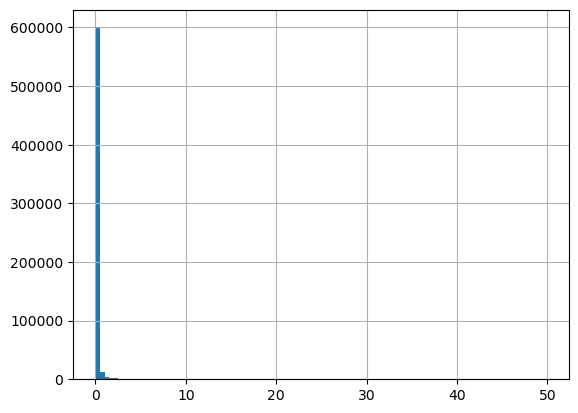

In [21]:
df_g_t[df_g_t['n_pe']>10]['energy'].hist(bins=100,grid=True)

In [22]:
df_nsb_=df_nsb[df_nsb['n_pe']==0].copy()

In [23]:
len(df_nsb_)

693931

In [24]:
df_nsb_['digitalsum_points_rate']=df_nsb_['n_digitalsum_points']/(1000.0/fadc_MHz*fadc_sum_bins*1e-9)/1e9

In [25]:
np.mean(df_nsb_['digitalsum_points_rate'].values)

8.325270904993912

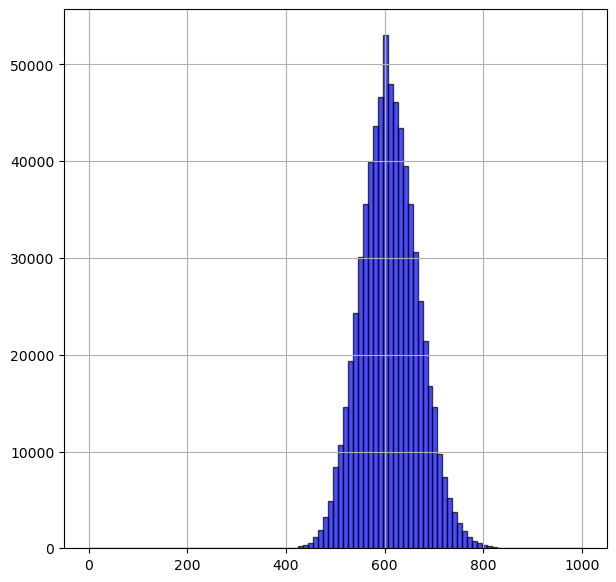

In [26]:
fig, ax00 = plt.subplots(figsize=(7,7))

df_nsb_['n_digitalsum_points'].hist(ax = ax00,bins=np.linspace(0,1000,100), alpha=0.7, color='b', edgecolor='black', density=False);
#ax00.set(xlabel='Digital sum micro-cluster rate, GHz', ylabel='');
#
ax00.yaxis.grid(True)
ax00.xaxis.grid(True)
#ax00.set_yscale('log')

#ax00.set_xlim(2,14)
#ax00.set_ylim(1,2*1e+5)


# Add mean and std annotations
#plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']), color='r', linestyle='dashed', linewidth=2)
#plt.text(12.0, 2.2e+4, f'Mean: {np.mean(df_nsb_['digitalsum_points_rate']):.2f} GHz', color='k')

# Add mean and std annotations
#plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']) + 2*np.std(df_nsb_['digitalsum_points_rate']), 
#            color='k', linestyle='dashed', linewidth=2)
#plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']) - 2*np.std(df_nsb_['digitalsum_points_rate']), 
#            color='k', linestyle='dashed', linewidth=2)
#plt.text(12.0, 1.2e+4, f'Std: {np.std(df_nsb_['digitalsum_points_rate']):.2f} GHz', color='k')

Text(12.0, 12000.0, 'Std: 0.78 GHz')

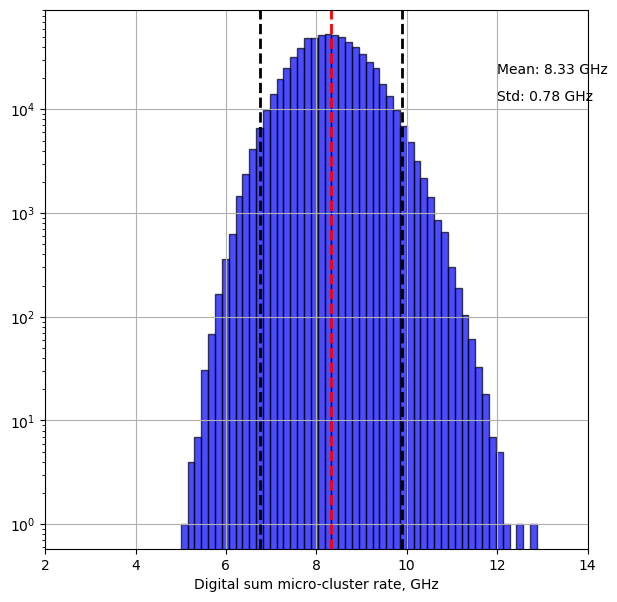

In [27]:
fig, ax01 = plt.subplots(figsize=(7,7))

df_nsb_['digitalsum_points_rate'].hist(ax = ax01,bins=np.linspace(0,15,100), alpha=0.7, color='b', edgecolor='black', density=False);
ax01.set(xlabel='Digital sum micro-cluster rate, GHz', ylabel='');
#
ax01.yaxis.grid(True)
ax01.xaxis.grid(True)
ax01.set_yscale('log')

ax01.set_xlim(2,14)
#ax01.set_ylim(1,2*1e+5)


# Add mean and std annotations
plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']), color='r', linestyle='dashed', linewidth=2)
plt.text(12.0, 2.2e+4, f'Mean: {np.mean(df_nsb_['digitalsum_points_rate']):.2f} GHz', color='k')

# Add mean and std annotations
plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']) + 2*np.std(df_nsb_['digitalsum_points_rate']), 
            color='k', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(df_nsb_['digitalsum_points_rate']) - 2*np.std(df_nsb_['digitalsum_points_rate']), 
            color='k', linestyle='dashed', linewidth=2)
plt.text(12.0, 1.2e+4, f'Std: {np.std(df_nsb_['digitalsum_points_rate']):.2f} GHz', color='k')

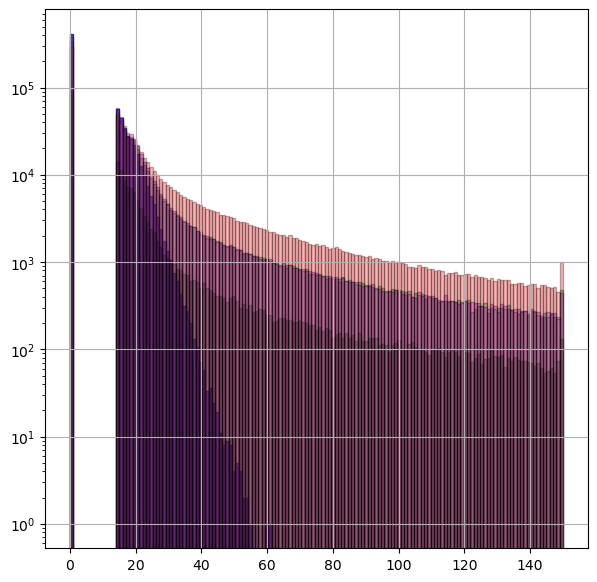

In [28]:
fig, ax02 = plt.subplots(figsize=(7,7))

df_nsb_['n_points'].hist(ax = ax02,bins=np.linspace(0,150,150), alpha=0.7, color='b', edgecolor='black', density=False);
df_g['n_points'].hist(ax = ax02,bins=np.linspace(0,150,150), alpha=0.3, color='r', edgecolor='black', density=False);
df_gd['n_points'].hist(ax = ax02,bins=np.linspace(0,150,150), alpha=0.3, color='g', edgecolor='black', density=False);
df_e['n_points'].hist(ax = ax02,bins=np.linspace(0,150,150), alpha=0.3, color='m', edgecolor='black', density=False);
df_p['n_points'].hist(ax = ax02,bins=np.linspace(0,150,150), alpha=0.2, color='k', edgecolor='black', density=False);

#
ax02.yaxis.grid(True)
ax02.xaxis.grid(True)
ax02.set_yscale('log')

In [29]:
rate_vs_th=[len(df_nsb_[df_nsb_['n_points']>=i])/len(df_nsb_['n_points'])*1.0/(1000.0/1024*75*1.0e-9) for i in np.arange(1,70)]

In [30]:
np.array(rate_vs_th)<30000

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

[Text(0.5, 0, 'Number of points in the DBSCAN cluster'),
 Text(0, 0.5, 'Rete, Hz')]

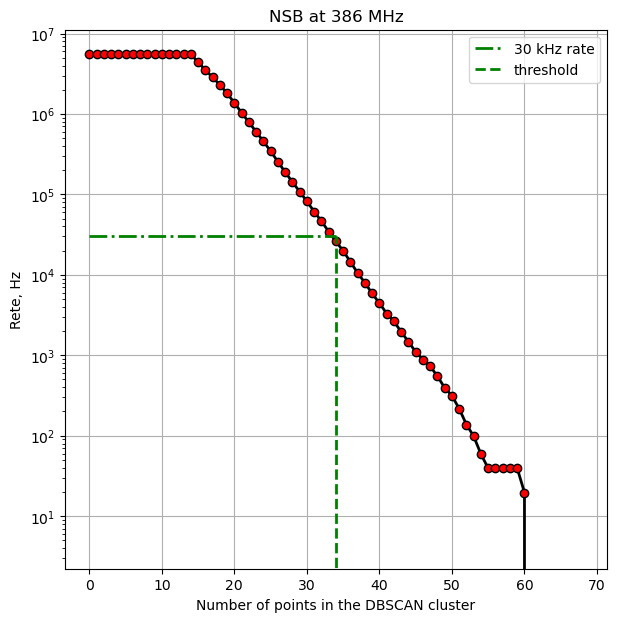

In [31]:
fig, ax03 = plt.subplots(figsize=(7,7))

#plt.plot(rate_vs_th,ax = ax03, alpha=0.7, color='b', density=False)
#ax03.scatter(np.arange(len(rate_vs_th)), rate_vs_th, c='r', lw =2, ls="-")
#ax03.plot(rate_vs_th, 'o-', c='k', lw =2, ls="-",mfc='red', mec='k')
ax03.plot(rate_vs_th, 'o-', c='k', lw =2, mfc='red', mec='k')
#
ax03.yaxis.grid(True)
ax03.xaxis.grid(True)
ax03.set_yscale('log')
#
plt.hlines(30000.0,0,34, color='g', linestyle='-.', linewidth=2, label='30 kHz rate')
plt.vlines(34,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
#
plt.legend()
#plt.title("sdsdsd: "r'$\mu$')
plt.title('NSB at 386 MHz')
#
ax03.set(xlabel='Number of points in the DBSCAN cluster', ylabel='Rete, Hz')

In [32]:
1.0/(1000.0/1024*75*1.0e-9)

13653333.333333332

<Axes: >

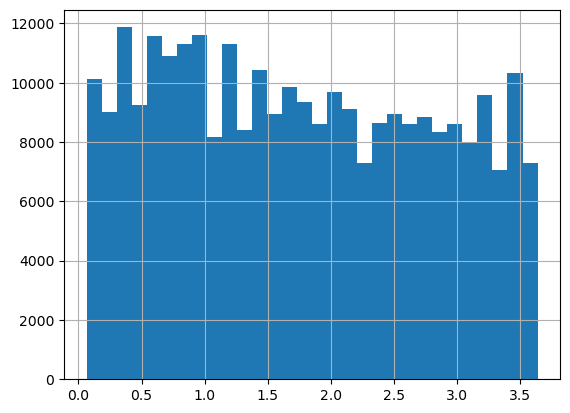

In [33]:
df_nsb_[df_nsb_['t_mean']>0]['t_mean'].hist(bins=30)

<Axes: >

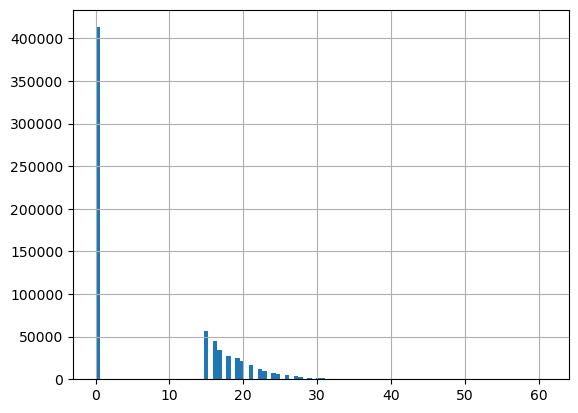

In [34]:
df_nsb_['n_points'].hist(bins=100)

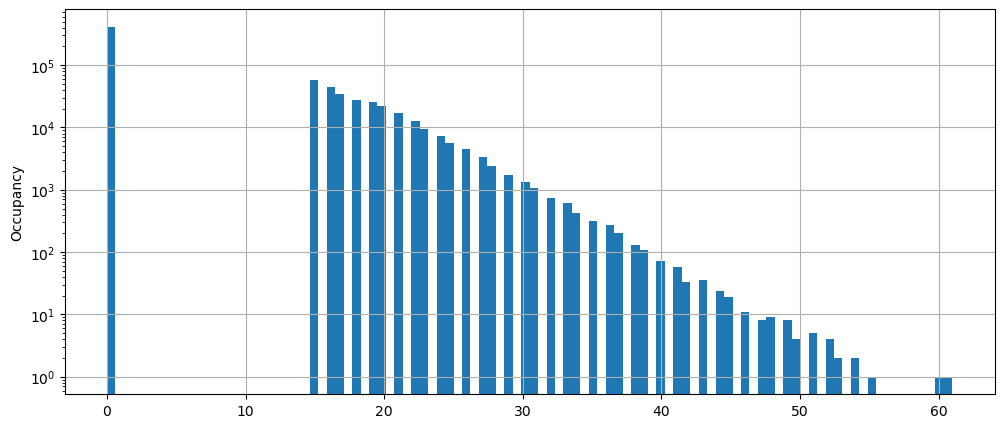

In [35]:
fig, ax04 = plt.subplots(figsize=(12,5))

df_nsb_['n_points'].hist(ax = ax04,bins=100);
ax04.set(xlabel='',ylabel='Occupancy');
#
ax04.yaxis.grid(True)
ax04.xaxis.grid(True)
ax04.set_yscale('log')

In [36]:
len(df_p[df_p['n_pe']>30])/71.0/1000000.0*get_proton_flux_pers( E_proton_min, E_proton_max, theta_proton_min_deg, theta_proton_max_deg, R_proton)

167205.5284595447

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

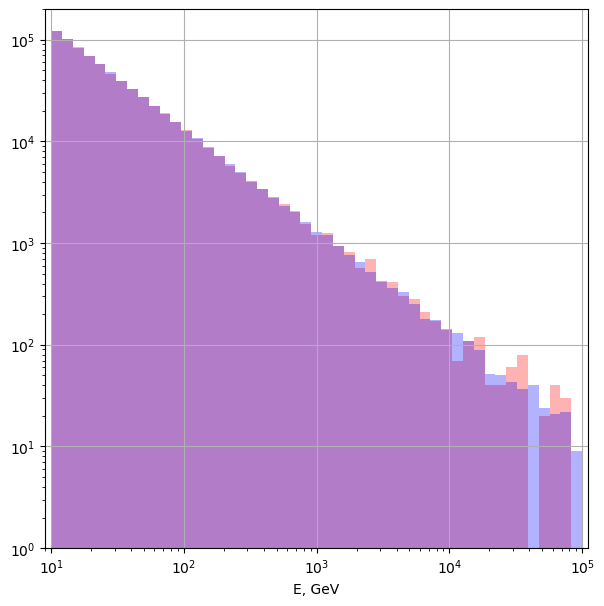

In [37]:
fig, ax05 = plt.subplots(figsize=(7,7))

#plt.plot(rate_vs_th,ax = ax03, alpha=0.7, color='b', density=False)
#ax03.scatter(np.arange(len(rate_vs_th)), rate_vs_th, c='r', lw =2, ls="-")
#ax03.plot(rate_vs_th, 'o-', c='k', lw =2, ls="-",mfc='red', mec='k')
#ax05.hist(df_nsb['energy']*1000,bins=np.logspace(1, 5, num=21))
ax05.hist(df_nsb['energy']*1000,bins=np.logspace(1, 5, num=50),color='r', alpha=0.3)
ax05.hist(generate_random_1_over_x_squared(len(df_nsb), 10, 100000),bins=np.logspace(1, 5, num=50),color='b', alpha=0.3)
#
ax05.yaxis.grid(True)
ax05.xaxis.grid(True)
ax05.set_yscale('log')
ax05.set_xscale('log')
ax05.set_xlim(9,110000)
ax05.set_ylim(1,2*1e+5)
#
#plt.hlines(30000.0,0,34, color='g', linestyle='-.', linewidth=2, label='30 kHz rate')
#plt.vlines(34,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
#
#plt.legend()
#plt.title("sdsdsd: "r'$\mu$')
#plt.title('NSB at 386 MHz')
#
ax05.set(xlabel='E, GeV', ylabel='')

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

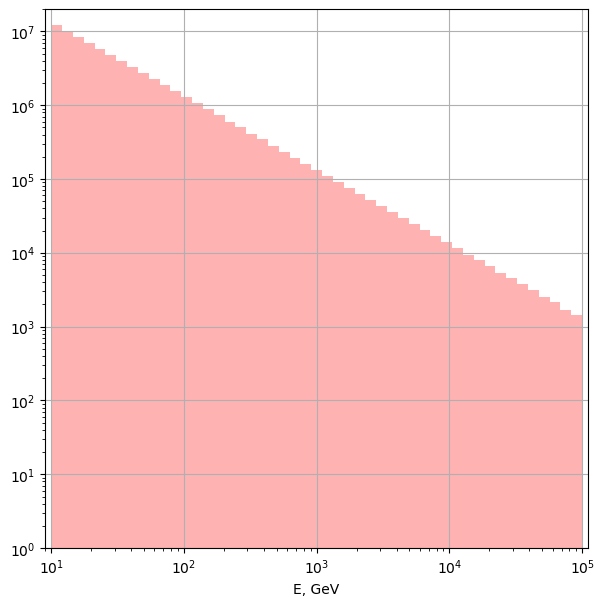

In [38]:
fig, ax06 = plt.subplots(figsize=(7,7))
#
ax06.hist(generate_random_1_over_x_squared(len(df_nsb)*100, 10, 100000),bins=np.logspace(1, 5, num=50),color='r', alpha=0.3)
#
ax06.yaxis.grid(True)
ax06.xaxis.grid(True)
ax06.set_yscale('log')
ax06.set_xscale('log')
ax06.set_xlim(9,110000)
ax06.set_ylim(1,2*1e+7)
#
ax06.set(xlabel='E, GeV', ylabel='')

In [39]:
np.logspace(1, 5, num=21)[:-1].reshape(4,5)

array([[1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
        6.30957344e+01],
       [1.00000000e+02, 1.58489319e+02, 2.51188643e+02, 3.98107171e+02,
        6.30957344e+02],
       [1.00000000e+03, 1.58489319e+03, 2.51188643e+03, 3.98107171e+03,
        6.30957344e+03],
       [1.00000000e+04, 1.58489319e+04, 2.51188643e+04, 3.98107171e+04,
        6.30957344e+04]])

In [40]:
len(df_nsb)

710000

In [41]:
np.sqrt(1.0/(np.random.uniform(1/10, 1/100000, len(df_nsb))))

array([3.8265111 , 4.20433703, 3.39594928, ..., 4.23524617, 3.23165638,
       3.62053948])

In [42]:
1/10

0.1

In [43]:
print(range(5))

range(0, 5)


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., 10.,
        21., 34., 19., 12.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([ 0.        ,  0.68965517,  1.37931034,  2.06896552,  2.75862069,
         3.44827586,  4.13793103,  4.82758621,  5.51724138,  6.20689655,
         6.89655172,  7.5862069 ,  8.27586207,  8.96551724,  9.65517241,
        10.34482759, 11.03448276, 11.72413793, 12.4137931 , 13.10344828,
        13.79310345, 14.48275862, 15.17241379, 15.86206897, 16.55172414,
        17.24137931, 17.93103448, 18.62068966, 19.31034483, 20.        ]),
 <BarContainer object of 29 artists>)

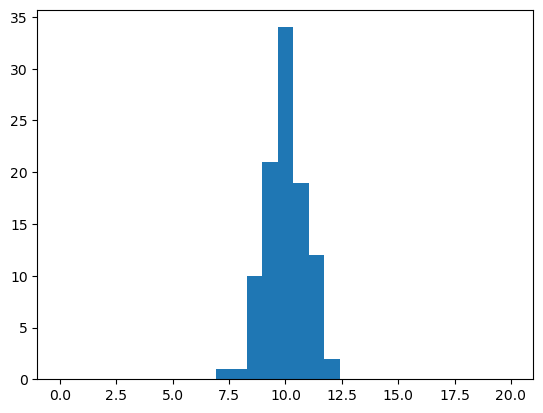

In [44]:
plt.hist(np.random.normal( 10, 1, 100),bins=np.linspace(0,20,30))

In [45]:
data_raw=np.random.normal( 10, 1, 100)

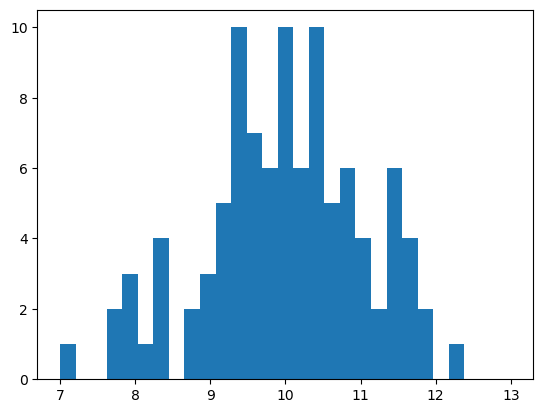

In [46]:
data=plt.hist(data_raw,bins=np.linspace(7,13,30))

In [47]:
len(data[0])

29

In [48]:
def gauss(x, ampl, mean, sigma):
    p = [ampl, mean, sigma]
    return p[0]* np.exp(-((x-p[1])**2/(2*p[2]**2)))

In [49]:
p0 = [20., 10., 1.0]

In [50]:
fit1, tmp1 = curve_fit(gauss, xdata=data[1][:-1], ydata=data[0], p0=p0)

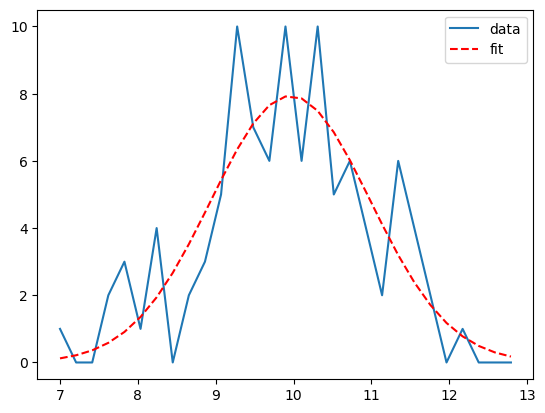

In [51]:
plt.plot(data[1][:-1], data[0], label='data')
plt.plot(data[1][:-1], gauss(data[1][:-1], *fit1), 'r--', label='fit')

plt.legend()

In [52]:
tmp1

array([[ 4.93916234e-01, -2.39562283e-05, -4.27056565e-02],
       [-2.39562283e-05,  1.09875251e-02,  7.06091034e-06],
       [-4.27056565e-02,  7.06091034e-06,  1.10442081e-02]])

In [53]:
(np.sqrt(1.00190752)/np.sqrt(1000))/np.sqrt(1.72175963e-03)

0.7628296372368839

In [54]:
fit1

array([7.93410935, 9.96222219, 1.0253173 ])

In [55]:
np.sqrt(1.05098153e-03)

0.032418845290972345

In [56]:
np.std(data_raw)/np.sqrt(1000)

0.03345375453164206

In [57]:
np.sqrt(tmp1[1,1])/(np.std(data_raw)/np.sqrt(100))

0.9908435222802908

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

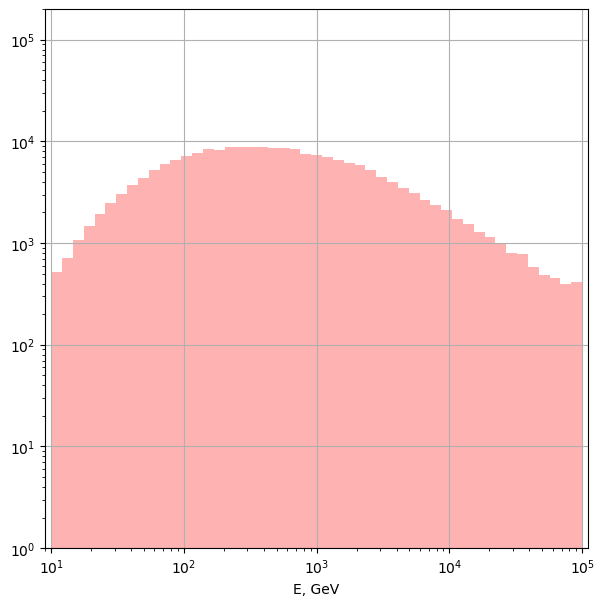

In [58]:
fig, ax07 = plt.subplots(figsize=(7,7))

ax07.hist(df_p['energy']*1000,bins=np.logspace(1, 5, num=50),color='r', alpha=0.3)
#
ax07.yaxis.grid(True)
ax07.xaxis.grid(True)
ax07.set_yscale('log')
ax07.set_xscale('log')
ax07.set_xlim(9,110000)
ax07.set_ylim(1,2*1e+5)
#
ax07.set(xlabel='E, GeV', ylabel='')

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

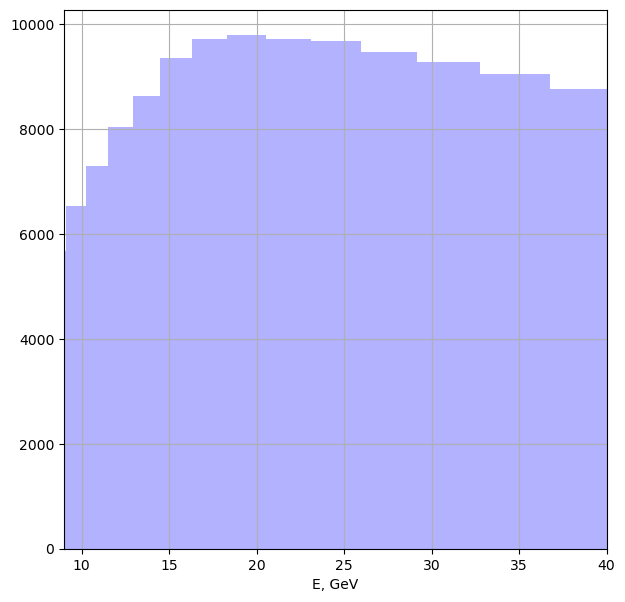

In [59]:
fig, ax08 = plt.subplots(figsize=(7,7))

#ax08.hist(df_g['energy']*1000,bins=np.logspace(0, 5, num=50),color='r', alpha=0.3)
ax08.hist(df_g[df_g['n_points']>36]['energy']*1000,bins=np.logspace(0, 5, num=100),color='b', alpha=0.3)
#
ax08.yaxis.grid(True)
ax08.xaxis.grid(True)
#ax08.set_yscale('log')
#ax08.set_xscale('log')
#ax08.set_xlim(9,110000)
ax08.set_xlim(9,40)
#ax08.set_ylim(1,2*1e+5)
#
ax08.set(xlabel='E, GeV', ylabel='')

In [60]:
len(df_p)/71/1e+6

0.002936042253521127

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

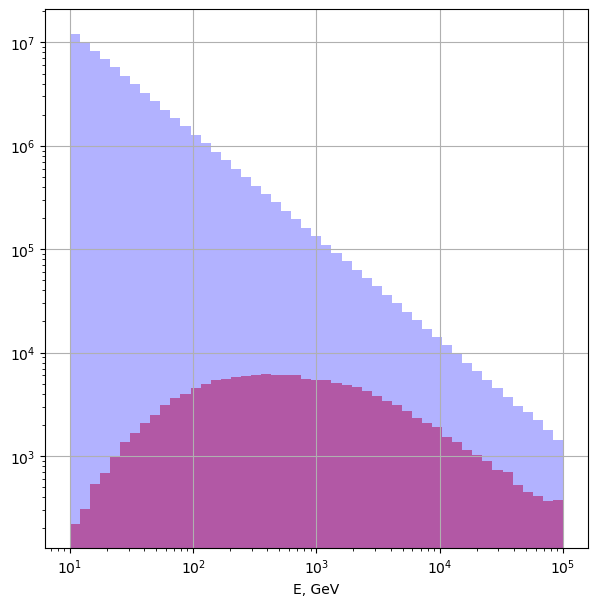

In [61]:
fig, ax09 = plt.subplots(figsize=(7,7))
#
hist_p_info=ax09.hist(df_p[df_p['n_pe']>=30]['energy']*1000,bins=np.logspace(1, 5, num=50),color='r', alpha=0.5)
hist_p_all_info=ax09.hist(generate_random_1_over_x_squared(int(71*1e+6), 10, 100000),bins=np.logspace(1, 5, num=50),color='b', alpha=0.3)
#
ax09.yaxis.grid(True)
ax09.xaxis.grid(True)
ax09.set_yscale('log')
ax09.set_xscale('log')
#ax08.set_xlim(9,110000)
#ax08.set_xlim(9,100)
#ax08.set_ylim(1,2*1e+5)
#
ax09.set(xlabel='E, GeV', ylabel='')

In [62]:
get_bin_centers(hist_p_info)

array([1.10339632e+01, 1.33157056e+01, 1.60692955e+01, 1.93923076e+01,
       2.34024941e+01, 2.82419576e+01, 3.40821866e+01, 4.11301319e+01,
       4.96355405e+01, 5.98998050e+01, 7.22866439e+01, 8.72349899e+01,
       1.05274544e+02, 1.27044545e+02, 1.53316422e+02, 1.85021129e+02,
       2.23282137e+02, 2.69455240e+02, 3.25176600e+02, 3.92420728e+02,
       4.73570447e+02, 5.71501330e+02, 6.89683599e+02, 8.32305092e+02,
       1.00441966e+03, 1.21212625e+03, 1.46278504e+03, 1.76527822e+03,
       2.13032477e+03, 2.57086025e+03, 3.10249523e+03, 3.74406842e+03,
       4.51831421e+03, 5.45266834e+03, 6.58024002e+03, 7.94098523e+03,
       9.58312254e+03, 1.15648418e+04, 1.39563659e+04, 1.68424397e+04,
       2.03253323e+04, 2.45284614e+04, 2.96007667e+04, 3.57219874e+04,
       4.31090315e+04, 5.20236620e+04, 6.27817724e+04, 7.57645809e+04,
       9.14321386e+04])

In [63]:
#fig, ax10 = plt.subplots(figsize=(7,7))
#
#hist_p_info=ax10.hist(df_p['energy']*1000,bins=np.logspace(1, 5, num=50),color='r', alpha=0.5)
#hist_p_all_info=ax10.hist(generate_random_1_over_x_squared(int(71*1e+6), 10, 100000),bins=np.logspace(1, 5, num=50),color='b', alpha=0.3)
#
#ax10.yaxis.grid(True)
#ax10.xaxis.grid(True)
#ax10.set_yscale('log')
#ax10.set_xscale('log')
#ax08.set_xlim(9,110000)
#ax10.set_xlim(9,100)
#ax08.set_ylim(1,2*1e+5)
#
#ax10.set(xlabel='E, GeV', ylabel='')
#for c in get_bin_centers(hist_p_info):
#    plt.vlines(c,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')

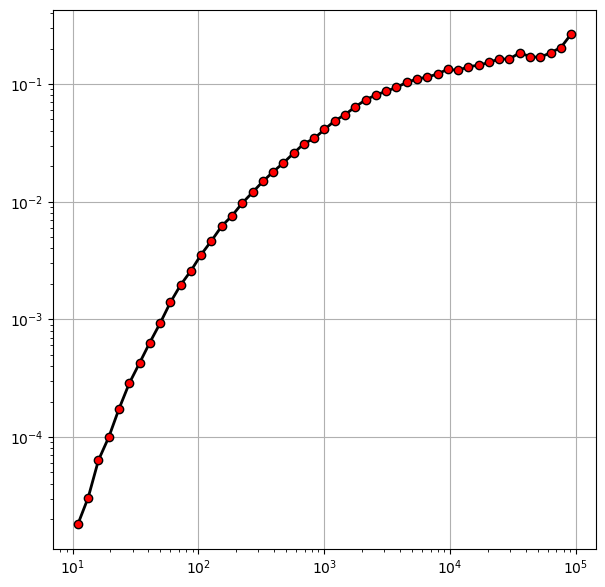

In [64]:
fig, ax11 = plt.subplots(figsize=(7,7))

#ax11.plot(get_bin_centers(hist_p_info),hist_p_info[0]/hist_p_all_info[0], c='r', lw = 2, ls="-")
ax11.plot(get_bin_centers(hist_p_info),hist_p_info[0]/hist_p_all_info[0], 'o-', c='k', lw =2, mfc='red', mec='k')
#
ax11.yaxis.grid(True)
ax11.xaxis.grid(True)
ax11.set_yscale('log')
ax11.set_xscale('log')
#
#plt.hlines(30000.0,0,34, color='g', linestyle='-.', linewidth=2, label='30 kHz rate')
#plt.vlines(34,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
#
#plt.legend()
#plt.title("sdsdsd: "r'$\mu$')
#plt.title('NSB at 386 MHz')
#
#ax03.set(xlabel='Number of points in the DBSCAN cluster', ylabel='Rete, Hz')

In [65]:
np.sum(hist_p_info[0]/hist_p_all_info[0])

3.3948713601250606

In [66]:
print(get_bin_min_max(hist_p_info)[:,1])

[1.20679264e+01 1.45634848e+01 1.75751062e+01 2.12095089e+01
 2.55954792e+01 3.08884360e+01 3.72759372e+01 4.49843267e+01
 5.42867544e+01 6.55128557e+01 7.90604321e+01 9.54095476e+01
 1.15139540e+02 1.38949549e+02 1.67683294e+02 2.02358965e+02
 2.44205309e+02 2.94705170e+02 3.55648031e+02 4.29193426e+02
 5.17947468e+02 6.25055193e+02 7.54312006e+02 9.10298178e+02
 1.09854114e+03 1.32571137e+03 1.59985872e+03 1.93069773e+03
 2.32995181e+03 2.81176870e+03 3.39322177e+03 4.09491506e+03
 4.94171336e+03 5.96362332e+03 7.19685673e+03 8.68511374e+03
 1.04811313e+04 1.26485522e+04 1.52641797e+04 1.84206997e+04
 2.22299648e+04 2.68269580e+04 3.23745754e+04 3.90693994e+04
 4.71486636e+04 5.68986603e+04 6.86648845e+04 8.28642773e+04
 1.00000000e+05]


In [67]:
print(len(hist_p_info[1][:-1]))
print(len(hist_p_info[1][1:]))

49
49


In [68]:
np.roll(np.pad(hist_p_info[1],1),1)

array([0.00000000e+00, 0.00000000e+00, 1.00000000e+01, 1.20679264e+01,
       1.45634848e+01, 1.75751062e+01, 2.12095089e+01, 2.55954792e+01,
       3.08884360e+01, 3.72759372e+01, 4.49843267e+01, 5.42867544e+01,
       6.55128557e+01, 7.90604321e+01, 9.54095476e+01, 1.15139540e+02,
       1.38949549e+02, 1.67683294e+02, 2.02358965e+02, 2.44205309e+02,
       2.94705170e+02, 3.55648031e+02, 4.29193426e+02, 5.17947468e+02,
       6.25055193e+02, 7.54312006e+02, 9.10298178e+02, 1.09854114e+03,
       1.32571137e+03, 1.59985872e+03, 1.93069773e+03, 2.32995181e+03,
       2.81176870e+03, 3.39322177e+03, 4.09491506e+03, 4.94171336e+03,
       5.96362332e+03, 7.19685673e+03, 8.68511374e+03, 1.04811313e+04,
       1.26485522e+04, 1.52641797e+04, 1.84206997e+04, 2.22299648e+04,
       2.68269580e+04, 3.23745754e+04, 3.90693994e+04, 4.71486636e+04,
       5.68986603e+04, 6.86648845e+04, 8.28642773e+04, 1.00000000e+05])

In [69]:
np.sum(get_proton_flux_pers(get_bin_min_max(hist_p_info)[:,0], get_bin_min_max(hist_p_info)[:,1], 
                            np.zeros(len(get_bin_min_max(hist_p_info)[:,1])), np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*10, 
                            np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*1500)*hist_p_info[0]/hist_p_all_info[0])

32301.3008032391

In [70]:
get_proton_flux_pers( 10, 100000, 0, 10, 1500)

82639605.44796683

In [71]:
e_min_max=get_bin_min_max(hist_p_info)
for i in np.arange(len(e_min_max)):
    emin=e_min_max[i,0]
    emax=e_min_max[i,1]
    print(emin)

10.0
12.067926406393289
14.563484775012437
17.57510624854792
21.209508879201906
25.59547922699536
30.888435964774818
37.2759372031494
44.98432668969444
54.286754393238596
65.51285568595509
79.06043210907697
95.40954763499938
115.1395399326447
138.94954943731375
167.68329368110065
202.35896477251555
244.205309454865
294.705170255181
355.64803062231283
429.1934260128778
517.9474679231213
625.0551925273969
754.3120063354615
910.2981779915218
1098.5411419875584
1325.7113655901082
1599.8587196060573
1930.6977288832495
2329.951810515372
2811.768697974228
3393.221771895326
4094.9150623804235
4941.713361323833
5963.623316594642
7196.856730011514
8685.11373751352
10481.131341546852
12648.552168552958
15264.179671752303
18420.699693267165
22229.96482526191
26826.957952797275
32374.5754281764
39069.39937054613
47148.663634573895
56898.66029018293
68664.88450042998
82864.27728546843


In [72]:
len(get_bin_min_max(hist_p_info)[:,1])

49

In [73]:
np.zeros(len(get_bin_min_max(hist_p_info)[:,1]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*10

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [75]:
n_points_cut = np.arange(15,200,1)

In [76]:
hist_data_proton=[ax09.hist(df_p[df_p['n_points']>=i]['energy']*1000,bins=np.logspace(1, 5, num=50),color='r', alpha=0.5) for i in n_points_cut]

In [77]:
hist_data_proton[0][0]

array([ 309.,  421.,  661.,  864., 1215., 1515., 1867., 2310., 2701.,
       3206., 3667., 3895., 4281., 4540., 4972., 4816., 5017., 4994.,
       4956., 4895., 4794., 4709., 4395., 4072., 4049., 3686., 3426.,
       3267., 3002., 2780., 2397., 2129., 1903., 1685., 1447., 1362.,
       1208.,  973.,  888.,  743.,  685.,  633.,  501.,  471.,  384.,
        322.,  285.,  251.,  271.])

In [78]:
np.arange(15,200,1)

array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 19

In [79]:
hist_data_proton[150][0]

array([  1.,   4.,   4.,  13.,  19.,  32.,  55.,  80., 103., 133., 172.,
       217., 280., 289., 372., 394., 447., 428., 479., 509., 474., 499.,
       448., 411., 389., 406., 365., 368., 321., 327., 282., 286., 240.,
       209., 217., 228., 213., 171., 194., 160., 160., 165., 130., 123.,
       122., 106.,  92.,  89.,  90.])

In [80]:
np.sum(get_proton_flux_pers(get_bin_min_max(hist_p_info)[:,0], get_bin_min_max(hist_p_info)[:,1], 
                            np.zeros(len(get_bin_min_max(hist_p_info)[:,1])), np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*10, 
                            np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*1500)*hist_data_proton[150][0]/hist_p_all_info[0])

1770.0901555477753

In [81]:
datay=[np.sum(get_proton_flux_pers(get_bin_min_max(hist_p_info)[:,0], get_bin_min_max(hist_p_info)[:,1], 
                            np.zeros(len(get_bin_min_max(hist_p_info)[:,1])), np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*10, 
                            np.ones(len(get_bin_min_max(hist_p_info)[:,1]))*1500)*hist_data_proton[i][0]/hist_p_all_info[0]) for i in np.arange(len(n_points_cut))]

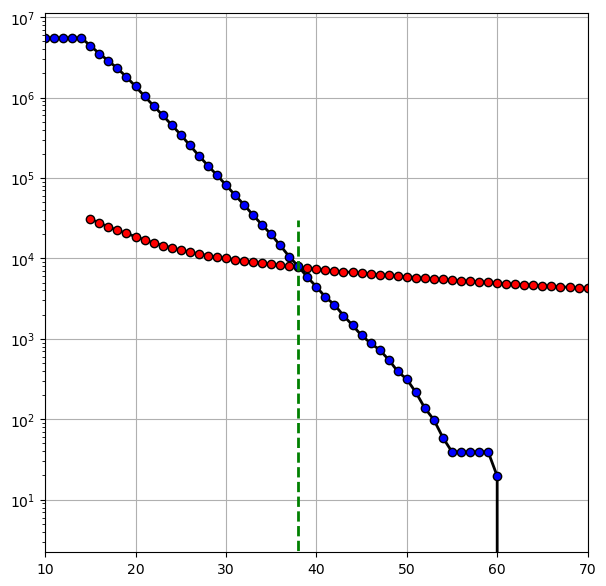

In [89]:
fig, ax12 = plt.subplots(figsize=(7,7))

ax12.plot(n_points_cut,datay, 'o-', c='k', lw =2, mfc='red', mec='k')
ax12.plot(rate_vs_th, 'o-', c='k', lw =2, mfc='blue', mec='k')

#
ax12.yaxis.grid(True)
ax12.xaxis.grid(True)
ax12.set_yscale('log')
ax12.set_xlim(10,70)

#ax12.set_xscale('log')
#
#plt.hlines(30000.0,0,34, color='g', linestyle='-.', linewidth=2, label='30 kHz rate')
#plt.vlines(34,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
plt.vlines(38,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
#
#plt.legend()
#plt.title("sdsdsd: "r'$\mu$')
#plt.title('NSB at 386 MHz')
#
#ax03.set(xlabel='Number of points in the DBSCAN cluster', ylabel='Rete, Hz')

In [83]:
#hist_g_all_info=ax09.hist(generate_random_1_over_x_squared(int(71*1e+5), 5, 50000),bins=np.logspace(0, 5, num=50),color='b', alpha=0.3)

[Text(0.5, 0, 'E, GeV'), Text(0, 0.5, '')]

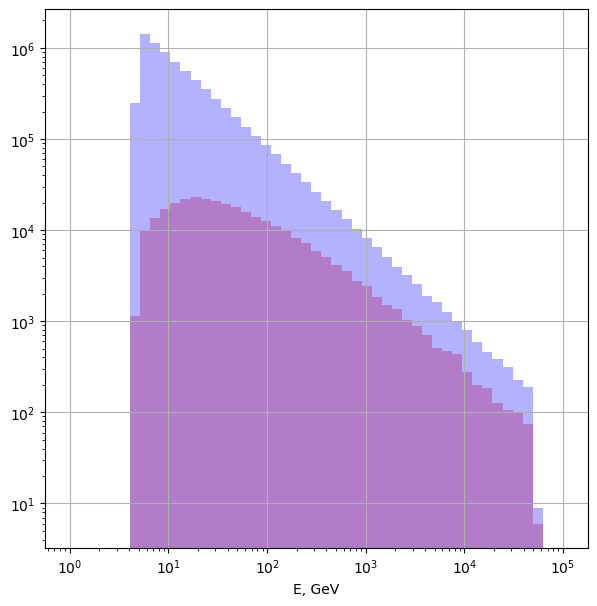

In [84]:
fig, ax13 = plt.subplots(figsize=(7,7))
#
hist_g_info=ax13.hist(df_g[df_g['n_points']>30]['energy']*1000,bins=np.logspace(0, 5, num=50),color='r', alpha=0.3)
hist_g_all_info=ax13.hist(generate_random_1_over_x_squared(int(71*1e+5), 5, 50000),bins=np.logspace(0, 5, num=50),color='b', alpha=0.3)
#
ax13.yaxis.grid(True)
ax13.xaxis.grid(True)
ax13.set_yscale('log')
ax13.set_xscale('log')
#
ax13.set(xlabel='E, GeV', ylabel='')

/tmp/ipykernel_17327/2593744265.py:3: RuntimeWarning: invalid value encountered in divide
  ax14.plot(get_bin_centers(hist_p_info),hist_g_info[0]/hist_g_all_info[0], 'o-', c='k', lw =2, mfc='red', mec='k')


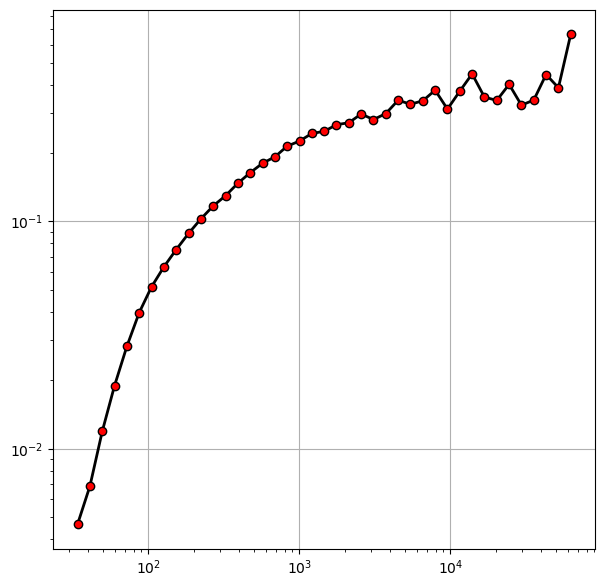

In [85]:
fig, ax14 = plt.subplots(figsize=(7,7))

ax14.plot(get_bin_centers(hist_p_info),hist_g_info[0]/hist_g_all_info[0], 'o-', c='k', lw =2, mfc='red', mec='k')
#ax14.plot(get_bin_centers(hist_p_info),hist_g_info[0]/hist_g_all_info[0])
#
ax14.yaxis.grid(True)
ax14.xaxis.grid(True)
ax14.set_yscale('log')
ax14.set_xscale('log')
#
#plt.hlines(30000.0,0,34, color='g', linestyle='-.', linewidth=2, label='30 kHz rate')
#plt.vlines(34,1,30000.0, color='g', linestyle='--', linewidth=2, label='threshold')
#
#plt.legend()
#plt.title("sdsdsd: "r'$\mu$')
#plt.title('NSB at 386 MHz')
#
#ax03.set(xlabel='Number of points in the DBSCAN cluster', ylabel='Rete, Hz')

In [86]:
hist_g_all_info[0]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 2.456550e+05, 1.434870e+06,
       1.134595e+06, 8.976070e+05, 7.092140e+05, 5.595430e+05,
       4.436180e+05, 3.503350e+05, 2.773340e+05, 2.197150e+05,
       1.736010e+05, 1.366700e+05, 1.086190e+05, 8.566800e+04,
       6.767300e+04, 5.359600e+04, 4.232900e+04, 3.353500e+04,
       2.641400e+04, 2.092800e+04, 1.676100e+04, 1.319500e+04,
       1.020500e+04, 8.270000e+03, 6.565000e+03, 5.079000e+03,
       3.952000e+03, 3.180000e+03, 2.578000e+03, 1.879000e+03,
       1.609000e+03, 1.251000e+03, 9.850000e+02, 7.920000e+02,
       5.900000e+02, 4.640000e+02, 3.850000e+02, 3.130000e+02,
       2.280000e+02, 1.910000e+02, 9.000000e+00, 0.000000e+00,
       0.000000e+00])